In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from yahoo_fin import stock_info
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

In [2]:
#Import data
tcsweekly = stock_info.get_data("RELIANCE.NS", interval="1d")
tcsweekly = tcsweekly.drop(['ticker'], axis=1)
tcsweekly=tcsweekly.dropna() #Remove Null Values
df=tcsweekly

In [3]:
train_df = tcsweekly.copy()

# List of considered Features
FEATURES = ['high', 'low', 'open', 'close', 'volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['prediction'] = data_filtered_ext['close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['high', 'low', 'open', 'close', 'volume']


,high,low,open,close,volume,prediction
2023-04-25,2380.600098,2350.500000,2366.000000,2376.050049,4262471.0,2376.050049
2023-04-26,2386.100098,2354.050049,2379.000000,2362.100098,3977129.0,2362.100098
2023-04-27,2384.000000,2364.000000,2375.000000,2377.050049,4230627.0,2377.050049
2023-04-28,2423.899902,2381.750000,2382.000000,2420.500000,7183342.0,2420.500000
2023-05-02,2445.800049,2428.100098,2436.199951,2441.050049,5988299.0,2441.050049


In [4]:
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(6870, 5)


In [5]:
np_data_scaled

array([[0.00142527, 0.00143888, 0.00141436, 0.00143405, 0.0718629 ],
       [0.00142935, 0.00141099, 0.00142116, 0.00138997, 0.11646393],
       [0.00172038, 0.00148349, 0.00148236, 0.00143267, 0.14447199],
       ...,
       [0.83399899, 0.84785551, 0.83083794, 0.84230539, 0.006327  ],
       [0.84802721, 0.85425343, 0.83329899, 0.85777925, 0.01074286],
       [0.85572698, 0.87096016, 0.85235454, 0.86509775, 0.00895564]])

In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 60

# Prediction Index
index_Close = data.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(5436, 60, 5) (5436,)
(1374, 60, 5) (1374,)
0.0013073114465831977
0.0013073114465831977


In [7]:
# Configure the neural network model
model = keras.Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(layers.LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(layers.LSTM(n_neurons, return_sequences=False))
model.add(layers.Dense(5))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

300 60 5


2023-05-02 23:17:45.686502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
epochs = 10
batch_size = 100
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/10
55/55 [==============================] - 63s 1s/step - loss: 7.4762e-04 - val_loss: 0.0041
Epoch 2/10
55/55 [==============================] - 59s 1s/step - loss: 2.9428e-05 - val_loss: 0.0032
Epoch 3/10
55/55 [==============================] - 58s 1s/step - loss: 2.8780e-05 - val_loss: 0.0034
Epoch 4/10
55/55 [==============================] - 58s 1s/step - loss: 2.7289e-05 - val_loss: 0.0028
Epoch 5/10
55/55 [==============================] - 57s 1s/step - loss: 2.9492e-05 - val_loss: 0.0029
Epoch 6/10
55/55 [==============================] - 58s 1s/step - loss: 2.5108e-05 - val_loss: 0.0024
Epoch 7/10
55/55 [==============================] - 58s 1s/step - loss: 2.6648e-05 - val_loss: 0.0019
Epoch 8/10
55/55 [==============================] - 58s 1s/step - loss: 2.4344e-05 - val_loss: 0.0011
Epoch 9/10
55/55 [==============================] - 58s 1s/step - loss: 2.4778e-05 - val_loss: 0.0022
Epoch 10/10
55/55 [==============================] - 58s 1s/step - loss: 2.6210e-0

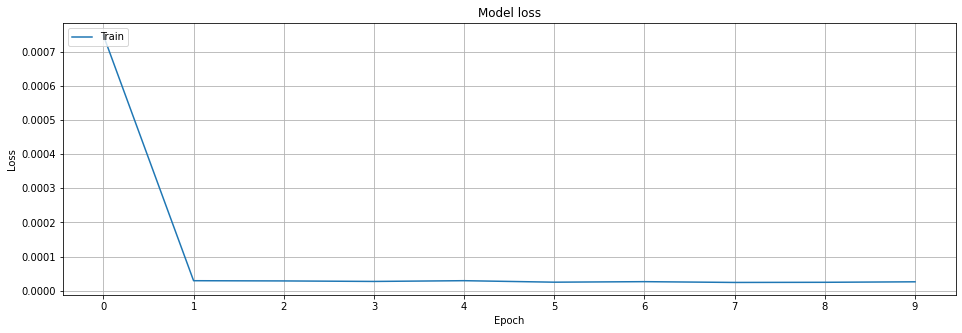

In [9]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [10]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

43/43 [==============================] - 8s 154ms/step
Median Absolute Error (MAE): 85.23
Mean Absolute Percentage Error (MAPE): 4.44 %
Median Absolute Percentage Error (MDAPE): 4.15 %


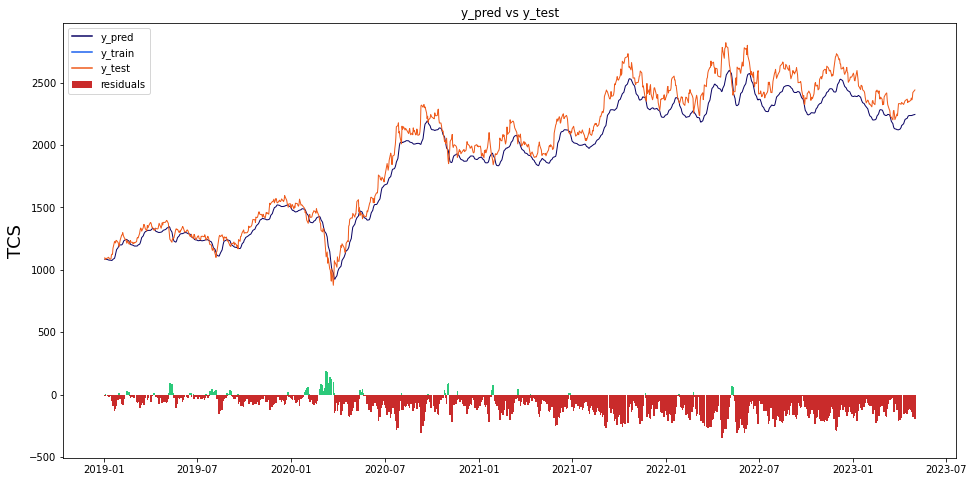

In [11]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['close'][:train_data_len + 1]).rename(columns={'close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['close'][train_data_len:]).rename(columns={'close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('TCS', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [12]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for TCS at today was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 41ms/step
The close price for TCS at today was 2441.05
The predicted close price is 2253.860107421875 (-8.31%)
